In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [287]:
#normalize data
def normalize_features(df):
    return df.divide(df.max(axis=0),axis=1)

#feature_rebase maps categorical data to numerical
#new_values is a dictionary {existing:desired}
#used to map male/female to 0-1, port to numeric (1-3), etc
def feature_rebase(train,test,col_name,new_col,new_values):
    key_list = list(new_values.keys())
    if 'default' in new_values.keys():
        train[new_col] = new_values['default']
        test[new_col] = new_values['default']
        key_list.remove('default')
        
    for k in key_list:
        train.loc[train[col_name]==k,new_col] = new_values[k]
        test.loc[test[col_name]==k,new_col] = new_values[k]
        #train[new_col].loc[train[train[col_name]==k].index] = new_values[k]
        #test[new_col].loc[test[test[col_name]==k].index] = new_values[k]
        
    return train, test

def fill_by_mode(df, tgt_col, rel_cols=None, null_val = np.nan):
    if rel_cols == None:
        #select rel_cols based on highest correlation, arbitrary cutoff at 7
        hunt_corr = abs(df.corr()[tgt_col])
        end = np.min((len(hunt_corr[1:]),7))
        rel_cols = list(hunt_corr.sort_values(ascending=False)[1:end].index)
    
    print('by mode: ',tgt_col, rel_cols)
    summ_dict = {}
    summ_dict['rel_cols'] = rel_cols
    k_used = list()
    hunt_dict = {}
    gs = df.copy()
    
    tgt_ind = list(df[df[tgt_col].isna()].index)
    for i in tgt_ind:
        for col in rel_cols:
            hunt_dict[col] = df.loc[i, col]
        
        for k in hunt_dict:
            if len(gs.loc[gs[gs[k] == hunt_dict[k]].index]) > 1:
                gs = gs.loc[gs[gs[k] == hunt_dict[k]].index]
                k_used.append(k)
        
        if len(gs[tgt_col].mode()) == 0:
                df.loc[i, tgt_col] = null_val
        else: 
            df.loc[i, tgt_col] = gs[tgt_col].mode()
        summ_dict[i] = k_used
        hunt_dict = {}
        k_used = list()
    
    return df, pd.DataFrame.from_dict(summ_dict, orient='index')


def fill_by_mean(df, tgt_col, rel_cols=None, null_val = np.nan):
    df = df
    tgt_col = tgt_col
    if rel_cols == None:
        #select rel_cols based on highest correlation, arbitrary cutoff at 7
        hunt_corr = abs(df.corr()[tgt_col])
        end = np.min((len(hunt_corr[1:]),7))
        rel_cols = list(hunt_corr.sort_values(ascending=False)[1:end].index)
    
    print('by mean: ',tgt_col, rel_cols)
    summ_dict = {}
    summ_dict['rel_cols'] = rel_cols
    k_used = list()
    hunt_dict = {}
    gs = df
    tgt_ind = list(df[df[tgt_col].isna()].index)
    for i in tgt_ind:

        for col in rel_cols:
            hunt_dict[col] = df.loc[i, col]
        
        for k in hunt_dict:
            if len(gs.loc[gs[gs[k] == hunt_dict[k]].index]) > 1:
                gs = gs.loc[gs[gs[k] == hunt_dict[k]].index]
                k_used.append(k)
        
        if len(gs[tgt_col]) == 0:
                df.loc[i, tgt_col] = null_val
        else: 
            df.loc[i, tgt_col] = gs[tgt_col].mean()
        
        summ_dict[i] = k_used
        hunt_dict = {}
        k_used = list()
        gs = df
    
    return df, pd.DataFrame.from_dict(summ_dict, orient='index')

# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   


# load data, set index, review where missing values are

In [325]:
file_loc = '/Users/gregscanlon/Documents/Kaggle/titanic/'
init_train = pd.read_csv(file_loc+'train.csv')
init_test = pd.read_csv(file_loc+'test.csv')

train = init_train
#ind = 'PassengerId'
#train.set_index(ind,inplace=True)
test = init_test
#test.set_index(ind,inplace=True)

#check data
check_dict = {'Sex':2,'Embarked': 3,'Pclass':3}

for k in check_dict:
    
    print('train unique match: ', k, len(train[k].unique())==check_dict[k])
    print('test unique match: ', k, len(test[k].unique())==check_dict[k])

train_na = list()
for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        train_na.append(col)
        
test_na = list()
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))
        test_na.append(col)

train unique match:  Sex True
test unique match:  Sex True
train unique match:  Embarked False
test unique match:  Embarked True
train unique match:  Pclass True
test unique match:  Pclass True
na in train  Age % of total:  0.19865319865319866
na in train  Cabin % of total:  0.7710437710437711
na in train  Embarked % of total:  0.002244668911335578
na in test  Age % of total:  0.20574162679425836
na in test  Fare % of total:  0.0023923444976076554
na in test  Cabin % of total:  0.7822966507177034


# Detect Outliers

In [326]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0)

# Feature Generation, Part A

In [327]:
#feature generation
#first generate some features so we can then fill values
columns = ['Pclass','SibSp','Parch','Age']

#male-female to 0 1
#male: 0
#female: 1
col_name = 'Sex'
new_col = 'm_f'
new_values = {'default':0,'female':1}

train, test = feature_rebase(train,test,col_name,new_col,new_values)

columns.append(new_col)

#embarked
#nan:0
#S:1
#C:2
#Q:3
col_name = 'Embarked'
new_col = 'embark_num'
new_values = {'default':np.nan,'S':1,'C':2,'Q':3}

train, test = feature_rebase(train,test,col_name,new_col,new_values)

columns.append(new_col)

#length of name
col_name = 'Name'
new_col = 'name_len'
train[new_col] = train[col_name].str.len()/train[col_name].str.len().max()
test[new_col] = test[col_name].str.len()/test[col_name].str.len().max()

columns.append(new_col)


'''#normalize fare
col_name = 'Fare'
new_col = 'fare_norm'
train[new_col] = train[col_name]/train[col_name].max()
test[new_col] = test[col_name]/test[col_name].max()

columns.append(new_col)

#normalize age
col_name = 'Age'
new_col = 'age_norm'
train[new_col] = train[col_name]/train[col_name].max()
test[new_col] = test[col_name]/test[col_name].max()

columns.append(new_col)'''

col_name = 'Cabin'
new_col = 'cabin_bin'
train.loc[:,new_col] = (train[col_name].str.len()>0)*1
test.loc[:,new_col] = (test[col_name].str.len()>0)*1

col_name = 'Ticket'
new_col = 'ticket_alpha'
train.loc[:,new_col] = train[col_name].str.contains('[^\W\d_]')*1
test.loc[:,new_col] = test[col_name].str.contains('[^\W\d_]')*1

#line workers with Fare = $0 get Cabin = 'L' and Fare = $0.01
train.loc[train['Ticket']=='LINE','Cabin'] = 'L'
train.loc[train['Ticket']=='LINE','Fare'] = 0.01
#train['Cabin'].loc[train[train['Ticket']=='LINE'].index] = 'L'
#train['Fare'].loc[train[train['Ticket']=='LINE'].index] = 0.01

train.loc[:,'cabin_alpha'] = train['Cabin'].str.extract(r'(\w)')
train.loc[:,'cabin_num'] = train['Cabin'].str.extract(r'(\d+)').astype(float)

test.loc[:,'cabin_alpha'] = test['Cabin'].str.extract(r'(\w)')
test.loc[:,'cabin_num'] = test['Cabin'].str.extract(r'(\d+)').astype(float)

#if you were a lower class parent/child, assign to 'ZP'
mask = (train['cabin_alpha'].isna())&(train['Pclass']==3)&(train['Parch']>0)
train.loc[mask, 'cabin_alpha'] = 'ZP'
mask = (test['cabin_alpha'].isna())&(test['Pclass']==3)&(test['Parch']>0)
test.loc[mask, 'cabin_alpha'] = 'ZP'
#test['cabin_alpha'].loc[test[(test['cabin_alpha'].isna())&(test['Pclass']==3)&(test['Parch']>0)].index] = 'ZP'

#get last name for matching families
train_part = train['Name'].str.partition(',').drop(1,axis=1).rename(columns={0:'last_name',2:'first_name'})
train = train.merge(train_part,left_index=True, right_index=True)
test_part = test['Name'].str.partition(',').drop(1,axis=1).rename(columns={0:'last_name',2:'first_name'})
test = test.merge(test_part,left_index=True, right_index=True)

#create family size
train.loc[:,'family_size'] = train['SibSp'] + train['Parch'] + 1
test.loc[:,'family_size'] = test['SibSp'] + test['Parch'] + 1


#features from walk-through
#title
## get the title from the name
train.loc[:,"title"] = [i.split('.')[0] for i in train.Name]
train.loc[:,"title"] = [i.split(',')[1] for i in train.title]
## Let's fix that
train.loc[:,'title'] = train.title.apply(lambda x: x.strip())

'''## Let's replace some of the rare values with the keyword 'rare' and other word choice of our own. 
## train Data
title_dict = {}
title_list = list(train.title.unique())
title_dict['Mr'] = 'Mr'
title_list.remove('Mr')
title_dict['Ms'] = 'Miss'
title_list.remove('Ms')
title_dict['Mlle'] = 'Miss'
title_list.remove('Mlle')
title_dict['Mrs'] = 'Mrs'
title_list.remove('Mrs')
title_dict['Master'] = 'Master'
title_list.remove('Master')
title_dict['Miss'] = 'Miss'
title_list.remove('Miss')
title_dict['Mme'] = 'Mme'
title_list.remove('Mme')

#set rest to rare
#for t in title_list:
#    title_dict[t] = 'rare'

    
for i in train.index:
    train['title'].loc[i] = title_dict[train['title'].loc[i]]'''
    

## extract titles from name
test.loc[:,"title"] = [i.split('.')[0] for i in test.Name]
test.loc[:,"title"] = [i.split(',')[1] for i in test.title]
## Let's fix that
test.loc[:,'title'] = test.title.apply(lambda x: x.strip())

title_list = list(test.title.unique())

'''#set rest to rare
for t in title_list:
    if t not in title_dict.keys():
        title_dict[t] = 'rare'
    
for i in test.index:
    test['title'].loc[i] = title_dict[test['title'].loc[i]]
    
#compute rare_title 0-1 column
train['rare_title'] = (train['title']=='rare')*1
test['rare_title'] = (test['title']=='rare')*1'''

#bin ages
train.loc[:,'age_cat'] = pd.cut(train['Age'],[0,6,15,25,45,100],labels=['baby','child','young_adult','mid_life','old'])
test.loc[:,'age_cat'] = pd.cut(test['Age'],[0,6,15,25,45,100],labels=['baby','child','young_adult','mid_life','old'])

#bin family size
train.loc[:,'family_size_cat'] = pd.cut(train['family_size'],[0,1,4,5,100],labels=['single','small','medium','large'])
test.loc[:,'family_size_cat'] = pd.cut(test['family_size'],[0,1,4,5,100],labels=['single','small','medium','large'])

#title descrip column: normal, medicine, army, church, special
title_dict = dict(zip(['Mr','Mrs','Miss','Mme','Ms','Mlle','Master'],['normal']*len(['Mr','Mrs','Miss','Mme','Ms','Mlle','Master'])))
for i in ['Dr','Sir','Jonkheer','Dona','the Countess','Don','Lady']:
    title_dict[i] = 'social_high'

title_dict['Rev'] = 'social_low'

for i in ['Dr','Sir','Jonkheer','Dona','the Countess','Don','Lady']:
    title_dict[i] = 'social_high'
    
for i in ['Col','Major']:
    title_dict[i] = 'army_high'
    
title_dict['Capt'] = 'army_low'

for title in title_dict:
    mask = train.title==title
    train.loc[mask,'title_class'] = title_dict[title]
    mask = test.title==title
    test.loc[mask,'title_class'] = title_dict[title]
    
#compute age range for family group 
i='last_name'
range_group = train.groupby(i)['Age'].max()-train.groupby(i)['Age'].min()
train = train.merge(range_group,how='left',left_on=i,right_on=i)

train.rename(columns={"Age_y": "last_age_range","Age_x":'Age'}, inplace=True)
train['last_age_range'].fillna(0,inplace=True)

range_group = test.groupby(i)['Age'].max()-test.groupby(i)['Age'].min()
test = test.merge(range_group,how='left',left_on=i,right_on=i)

test.rename(columns={"Age_y": "last_age_range","Age_x":'Age'}, inplace=True)
test['last_age_range'].fillna(0,inplace=True)

#compute age range for ticket group
range_group = train.groupby('Ticket')['Age'].max()-train.groupby('Ticket')['Age'].min()
train = train.merge(range_group,how='left',left_on='Ticket',right_on='Ticket')

train.rename(columns={"Age_y": "ticket_age_range","Age_x":'Age'}, inplace=True)
train['ticket_age_range'].fillna(0,inplace=True)

range_group = test.groupby('Ticket')['Age'].max()-test.groupby('Ticket')['Age'].min()
test = test.merge(range_group,how='left',left_on='Ticket',right_on='Ticket')

test.rename(columns={"Age_y": "ticket_age_range","Age_x":'Age'}, inplace=True)
test['ticket_age_range'].fillna(0,inplace=True)

#bin the age ranges
train.loc[:,'ticket_rg_cat'] = pd.cut(train.ticket_age_range,bins=[-1,1,13,30,50],labels=["Alone", "a_rg", "b_rg",'c_rg'])
test.loc[:,'ticket_rg_cat'] = pd.cut(test.ticket_age_range,bins=[-1,1,13,30,50],labels=["Alone", "a_rg", "b_rg",'c_rg'])

train.loc[:,'last_rg_cat'] = pd.cut(train.last_age_range,bins=[-1,1,13,30,50],labels=["last_Alone", "last_a_rg", "last_b_rg",'last_c_rg'])
test.loc[:,'last_rg_cat'] = pd.cut(test.last_age_range,bins=[-1,1,13,30,50],labels=["last_Alone", "last_a_rg", "last_b_rg",'last_c_rg'])

#compute family survival rate 
'''i = 'last_name'
totals = train.groupby([i]).count() 
lived = train[(train.Survived==1)].groupby([i]).count()
train = train.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
train.rename(columns={"Pclass_y": "fam_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
train['fam_surv_rate'].fillna(0,inplace=True)

#share this info where possible with test
test = test.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
test.rename(columns={"Pclass_y": "fam_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
test['fam_surv_rate'].fillna(0,inplace=True)'''

#compute ticket survival rate 
i = 'Ticket'
totals = train.groupby([i]).count() 
lived = train[(train.Survived==1)].groupby([i]).count()
train = train.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
train.rename(columns={"Pclass_y": "tick_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
train['tick_surv_rate'].fillna(0,inplace=True)

#share this info where possible with test
test = test.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
test.rename(columns={"Pclass_y": "tick_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
test['tick_surv_rate'].fillna(0,inplace=True)


#clean the family and ticket survival rate


In [319]:
#compute family survival rate 
i = 'Ticket'
totals = train[train.m_f==0].groupby([i]).count() 
lived = train[(train.m_f==0)&(train.Survived==1)].groupby([i]).count()
#train.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
#train.rename(columns={"Pclass_y": "fam_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
#train['fam_surv_rate'].fillna(0,inplace=True)
male = lived/totals
#train.merge(male['Pclass'],how='left',left_on=i,right_on=i)

In [321]:
train.columns

Index(['Survived', 'Pclass_x', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name',
       'first_name', 'family_size', 'title', 'age_cat', 'family_size_cat',
       'title_class', 'last_age_range', 'ticket_age_range', 'ticket_rg_cat',
       'last_rg_cat', 'fam_surv_rate', 'tick_surv_rate', 'tix_group',
       'adj_fare', 'Pclass_y'],
      dtype='object')

In [312]:
train[train.family_size_cat=='large'].sort_values('last_name')

,Survived,Pclass_x,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,title_class,last_age_range,ticket_age_range,ticket_rg_cat,last_rg_cat,fam_surv_rate,tick_surv_rate,tix_group,adj_fare,Pclass_y
13,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
603,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
67,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,...,normal,37.00,0.00,Alone,last_c_rg,0.222222,1.00,1,7.925000,0.333333
535,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
117,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
534,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
841,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,...,normal,37.00,37.00,c_rg,last_c_rg,0.222222,0.00,7,4.467857,0.333333
25,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,...,normal,35.00,35.00,c_rg,last_c_rg,0.750000,0.75,4,7.846875,0.500000
178,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,...,normal,35.00,35.00,c_rg,last_c_rg,0.750000,0.75,4,7.846875,0.500000


# Fill missing Fare, Age, Embarked, Cabin values

In [328]:
train.set_index('PassengerId',inplace=True)
test.set_index('PassengerId',inplace=True)
#after analyzing ticket number and sex, it seems the missing Embarked got on at port S
#train[train['Ticket'].str.startswith('113')].groupby(['Sex','Embarked']).count()
mask = train['Embarked'].isna()
train.loc[mask, 'Embarked'] = 'S'

mask = test['Embarked'].isna()
test.loc[mask, 'Embarked'] = 'S'

mask = train['embark_num'].isna()
train.loc[mask, 'embark_num'] = 1

mask = test['embark_num'].isna()
test.loc[mask, 'embark_num'] = 1

#train['Embarked'].loc[train[train['Embarked'].isna()].index] = 'S'
#train['embark_num'].loc[train[train['embark_num'].isna()].index] = 1

#I decided against estimated fares at 0
#set fares that are $0 to nan so we can estimate them for train and test
#train['Fare'].loc[train[train['Fare']==0].index] = np.nan
#test['Fare'].loc[test[test['Fare']==0].index] = np.nan

#store a summary of transformation results
train_summary = {}
test_summary = {}

#fill in missing values for Fare, Age, embark_num using most correlated features and mean,mode
train_na = ['Fare','Age']
rel_cols = ['title','Survived','Pclass','m_f','family_size_cat']
for col in train_na:
    if np.issubdtype(train[col].dtype , np.number):
        train, train_summary[col] = fill_by_mean(train,col, rel_cols = rel_cols, null_val = train[col].median())
        
    else:        
        train, train_summary[col] = fill_by_mode(train,col)


#assign Embarked using embark_num


#assign everyone to a cabin_alpha = class
train, train_summary['cabin_alpha'] = fill_by_mode(train,'cabin_alpha',['Fare','Pclass','Parch','m_f','Age','embark_num'],'U')
test, test_summary['cabin_alpha'] = fill_by_mode(test,'cabin_alpha',['Fare','Pclass','Parch','m_f','Age','embark_num'],'U')

test_na = ['Fare','Age']
rel_cols = ['title','Pclass','m_f','family_size_cat']

for col in test_na:
    if np.issubdtype(train[col].dtype , np.number):
        test, test_summary[col] = fill_by_mean(test,col, rel_cols = rel_cols, null_val = test[col].median())
        
    else:
        test, test_summary[col] = fill_by_mode(test,col)
        
#bin ages
train['age_cat'] = pd.cut(train['Age'],[0,6,15,25,45,100],labels=['baby','child','young_adult','mid_life','old'])
test['age_cat'] = pd.cut(test['Age'],[0,6,15,25,45,100],labels=['baby','child','young_adult','mid_life','old'])

#go through each passenger and see how many were under 1 ticket number
train['tix_group'] = 1
for i in train.index:
    train.loc[i,'tix_group'] = len(train[train['Ticket'] == train['Ticket'].loc[i]])
    
test['tix_group'] = 1
for i in test.index:
    test.loc[i,'tix_group'] = len(test[test['Ticket'] == test['Ticket'].loc[i]])
    
#compute group fare
train.loc[:,'adj_fare'] = train['Fare']/train['tix_group']
test.loc[:,'adj_fare'] = test['Fare']/test['tix_group']


print('Check for NA')
train_na = list()
for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        train_na.append(col)
        
test_na = list()
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))
        test_na.append(col)

by mean:  Fare ['title', 'Survived', 'Pclass', 'm_f', 'family_size_cat']
by mean:  Age ['title', 'Survived', 'Pclass', 'm_f', 'family_size_cat']
by mode:  cabin_alpha ['Fare', 'Pclass', 'Parch', 'm_f', 'Age', 'embark_num']
by mode:  cabin_alpha ['Fare', 'Pclass', 'Parch', 'm_f', 'Age', 'embark_num']
by mean:  Fare ['title', 'Pclass', 'm_f', 'family_size_cat']
by mean:  Age ['title', 'Pclass', 'm_f', 'family_size_cat']
Check for NA
na in train  Cabin % of total:  0.7673098751418842
na in train  cabin_num % of total:  1.0
na in test  Cabin % of total:  0.7822966507177034
na in test  cabin_num % of total:  1.0


# Prep data for train+test

In [329]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name',
       'first_name', 'family_size', 'title', 'age_cat', 'family_size_cat',
       'title_class', 'last_age_range', 'ticket_age_range', 'ticket_rg_cat',
       'last_rg_cat', 'tick_surv_rate', 'tix_group', 'adj_fare'],
      dtype='object')

In [330]:
numeric_cols = ['Pclass', 'Age', 'SibSp', 'Parch',
       'Fare', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'family_size', 'tix_group', 'adj_fare']

gs_cols_of_value = ['Pclass', 'SibSp','Parch','Age', 'm_f', 'embark_num', 'name_len',
        'family_size_cat', 'tix_group', 'adj_fare','age_cat','title_class','cabin_bin','ticket_age_range','last_age_range',
                   'ticket_rg_cat', 'last_rg_cat', 'tick_surv_rate']


X = train[gs_cols_of_value]
#X.set_index('PassengerId',inplace=True)
#X.drop('PassengerId',axis=1,inplace=True)

X = pd.get_dummies(X)

gs_test = test[gs_cols_of_value]
#gs_test.set_index('PassengerId',inplace=True)
#gs_test.drop('PassengerId',axis=1,inplace=True)
gs_test = pd.get_dummies(gs_test)
print(X.shape,gs_test.shape)
X.shape[0] == gs_test.shape[0]

(881, 35) (418, 34)


False

In [331]:
for col in X.columns:
    if col not in gs_test.columns:
        print(col)
        X.drop(col,axis=1,inplace=True)
        
for col in gs_test.columns:
    if col not in X.columns:
        print(col)

title_class_army_low


In [332]:
X.shape, gs_test.shape

((881, 34), (418, 34))

In [333]:
y = train['Survived']

X.to_excel(file_loc+'X_processed.xlsx')
y.to_excel(file_loc+'y_processed.xlsx',header=True)
gs_test.to_excel(file_loc+'gs_test_processed.xlsx')

# Explore Feature

In [363]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name',
       'first_name', 'family_size', 'title', 'rare_title', 'age_cat',
       'family_size_cat', 'tix_group', 'adj_fare'],
      dtype='object')

In [33]:
list_cols_factor = []

for col in list(train.columns):
    if pd.api.types.is_number(train[col].iloc[0]):
        list_cols_factor.append(col)
        
list_cols_factor

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'm_f',
 'embark_num',
 'name_len',
 'cabin_bin',
 'ticket_alpha',
 'cabin_num',
 'family_size',
 'tix_group',
 'adj_fare']

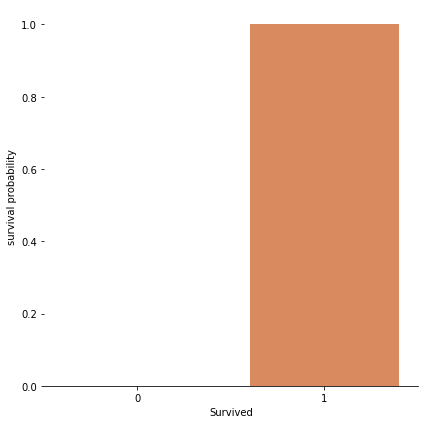

In [36]:
list_cols_factor = []

for col in list(train.columns):
    if pd.api.types.is_number(train[col].iloc[0]):
        list_cols_factor.append(col)
        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

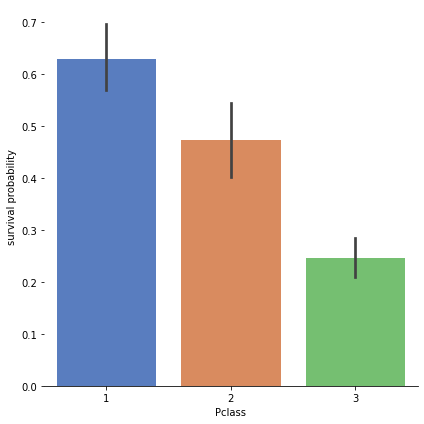

In [37]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

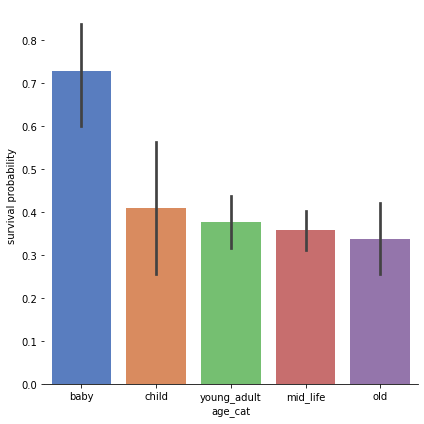

In [38]:
#list_cols_factor.pop(0)        

g = sns.catplot(x='age_cat',y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

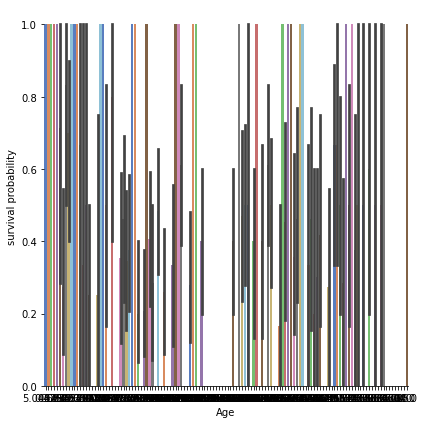

In [39]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

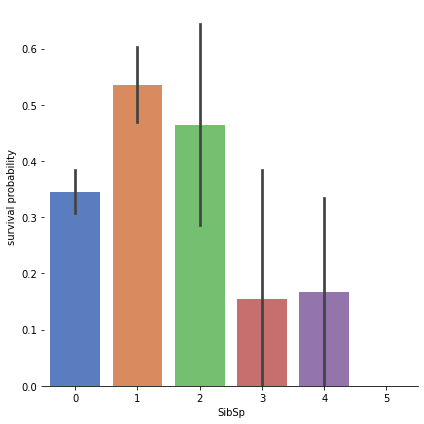

In [40]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

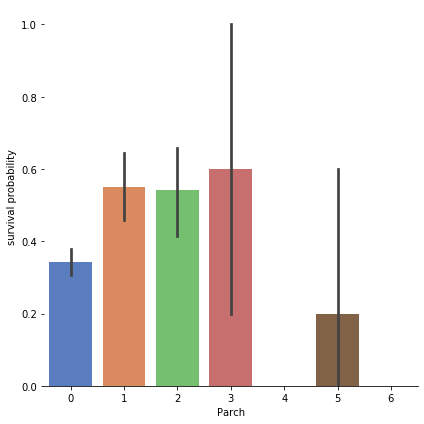

In [41]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

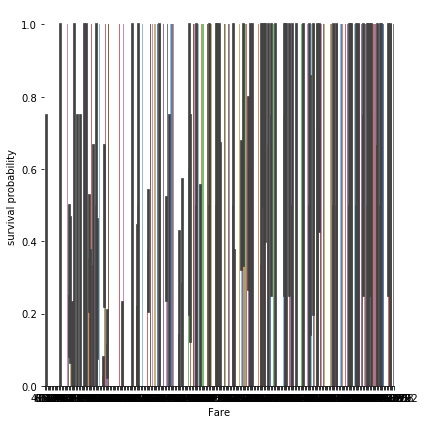

In [42]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

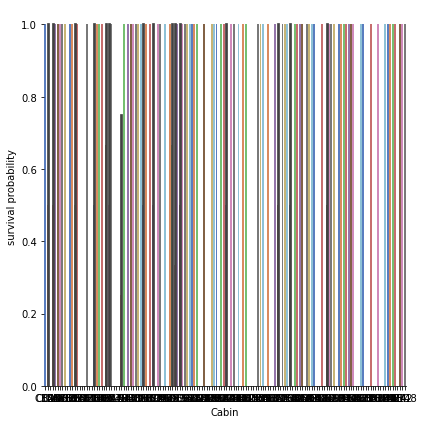

In [43]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

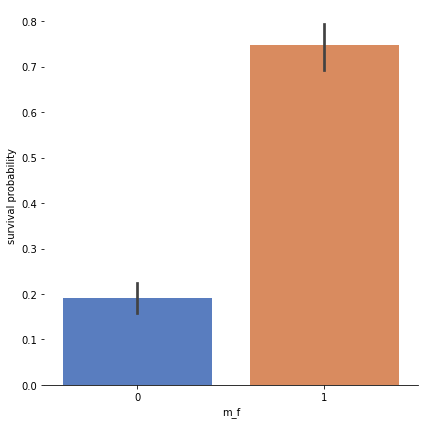

In [44]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

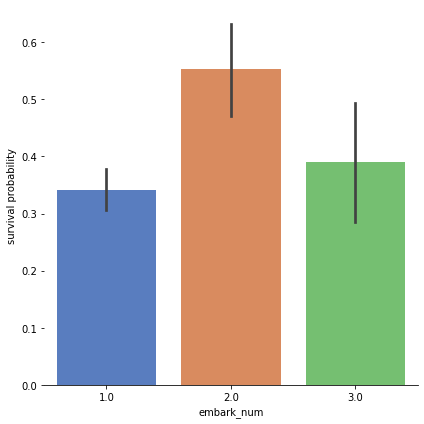

In [45]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

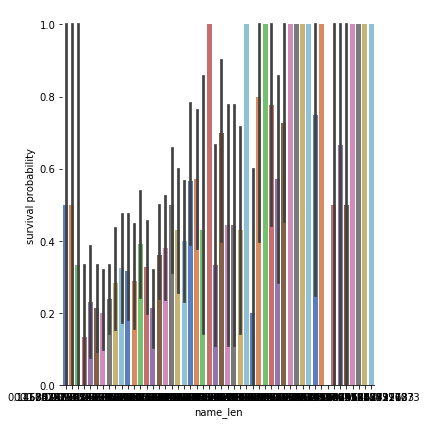

In [46]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

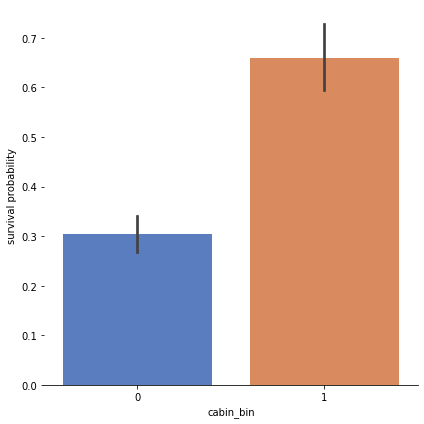

In [47]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

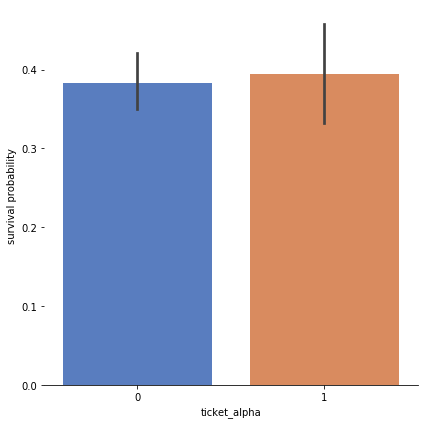

In [48]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

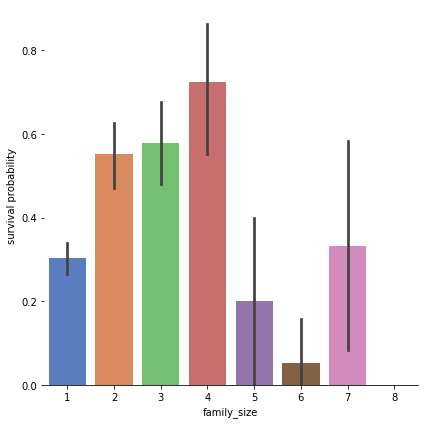

In [50]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

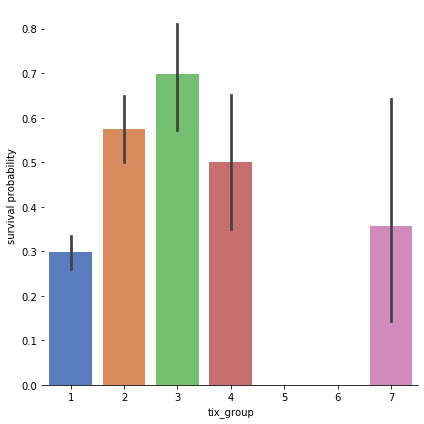

In [51]:
list_cols_factor.pop(0)        

g = sns.catplot(x=list_cols_factor[0],y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

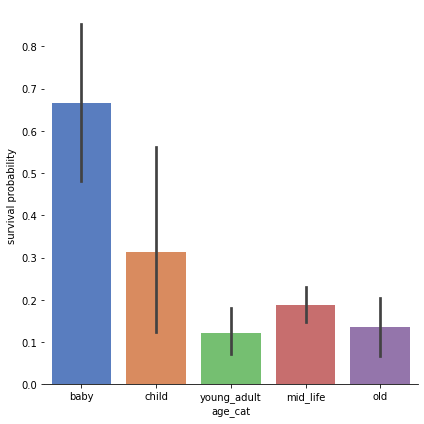

In [53]:
g = sns.catplot(x='age_cat',y="Survived",data=train[train.m_f==0],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

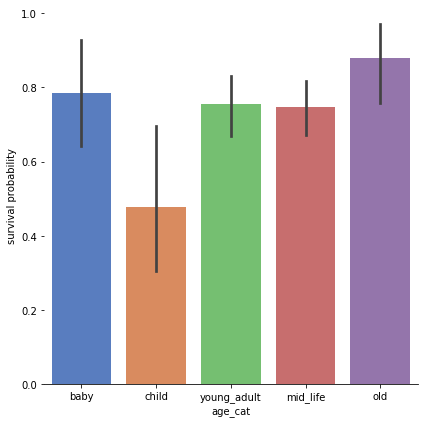

In [54]:
g = sns.catplot(x='age_cat',y="Survived",data=train[train.m_f==1],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

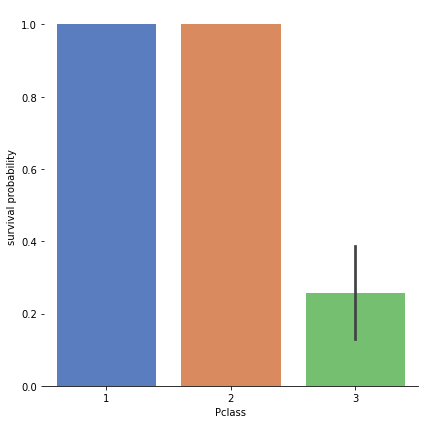

In [57]:
g = sns.catplot(x='Pclass',y="Survived",data=train[(train.age_cat=='child')],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

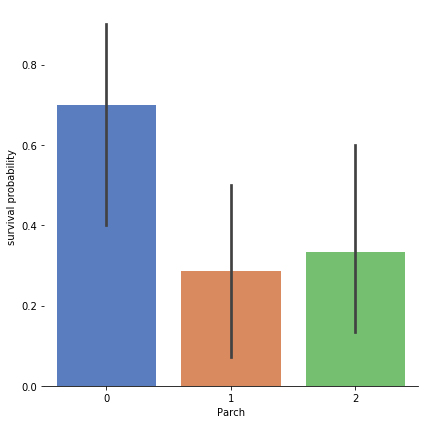

In [58]:
g = sns.catplot(x='Parch',y="Survived",data=train[(train.age_cat=='child')],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


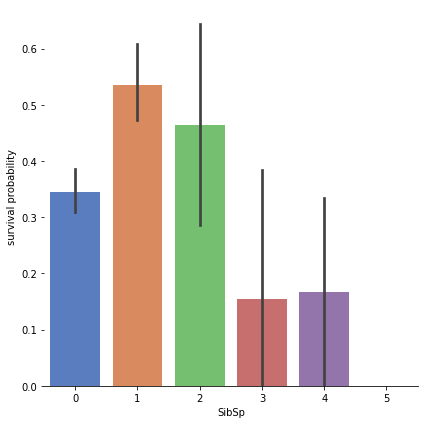

In [309]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

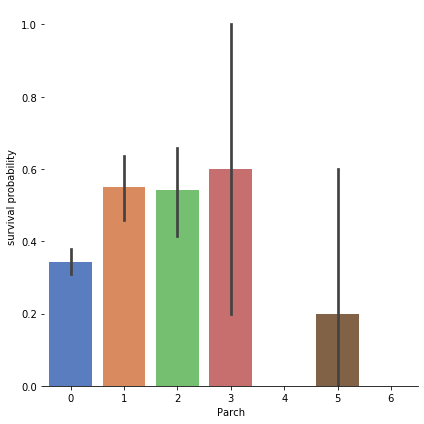

In [310]:
# Explore Parch feature vs Survived
#the black bar is the std deviation and note the size of std dev of Parch = 3 = LARGE
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# Takeaways from factorplots

Takeaways from factorplots above

pclass clear connection to survival and small std dev
age has connection, child cat has largest std dev
large std devs for Sibsp >1
large std devs for Parch >2
rare title vs no rare title = 50/50 but rare title has large std dev = need to drill down
investigate family size = 7
family size >4 = lower survival prob and higher std dev
investigate std dev of tix_group = 7

create multiple categories for fare and adjusted fare

ticket_alpha is useless



In [370]:
#drop ticket alpha because it is useless
#drop rare_title because it is useless
train.drop(['ticket_alpha','rare_title'],axis=1,inplace = True)
test.drop(['ticket_alpha','rare_title'],axis=1,inplace = True)

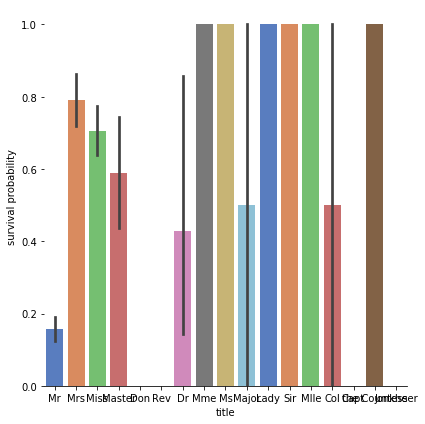

In [372]:
#find the titles associated with survival
## get the title from the name
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]
## Let's fix that
train.title = train.title.apply(lambda x: x.strip())

test["title"] = [i.split('.')[0] for i in test.Name]
test["title"] = [i.split(',')[1] for i in test.title]
## Let's fix that
test.title = test.title.apply(lambda x: x.strip())


#factor plot of family size vs survival
g  = sns.factorplot(x="title",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# Look closer at Pclass = 3 & m_f =1

In [135]:
these_cols = [
 'SibSp',
 'Parch',
 'embark_num',
 'family_size_cat',
 'tix_group',
 'adj_fare',
 'age_cat',
 'title_class',
 'cabin_bin','ticket_alpha']

train_dummies = pd.get_dummies(train[these_cols])


In [145]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name_x',
       'first_name_x', 'family_size', 'title', 'age_cat', 'family_size_cat',
       'last_name_y', 'first_name_y', 'tix_group', 'adj_fare', 'title_class'],
      dtype='object')

In [ ]:
train.groupby('last_name_x').count()

In [163]:
#compute survival rate for family group 
range_group = train.groupby('last_name_x')['Age'].max()-train.groupby('last_name_x')['Age'].min()
train = train.merge(range_group,how='left',left_on='last_name_x',right_on='last_name_x')

train.rename(columns={"Age_y": "last_age_range","Age_x":'Age'}, inplace=True)

#compute survival rate for ticket group 
range_group = train.groupby('Ticket')['Age'].max()-train.groupby('Ticket')['Age'].min()
train = train.merge(range_group,how='left',left_on='Ticket',right_on='Ticket')

train.rename(columns={"Age_y": "ticket_age_range","Age_x":'Age'}, inplace=True)

In [220]:
train.rename(columns={'Pclass_x':'Pclass'},inplace=True)
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name_x',
       'first_name_x', 'family_size', 'title', 'age_cat', 'family_size_cat',
       'last_name_y', 'first_name_y', 'tix_group', 'adj_fare', 'title_class',
       'last_age_range', 'ticket_age_range', 'ticket_rg_cat', 'last_rg_cat',
       'fam_surv_rate'],
      dtype='object')

In [227]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,last_name_y,first_name_y,tix_group,adj_fare,title_class,last_age_range,ticket_age_range,ticket_rg_cat,last_rg_cat,fam_surv_rate
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,...,Kelly,Mr. James,1,7.8292,normal,0.0,0.0,Alone,last_Alone,0.75
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,...,Wilkes,Mrs. James (Ellen Needs),1,7.0000,normal,0.0,0.0,Alone,last_Alone,0.00
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,...,Myles,Mr. Thomas Francis,1,9.6875,normal,0.0,0.0,Alone,last_Alone,0.00
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,...,Wirz,Mr. Albert,1,8.6625,normal,0.0,0.0,Alone,last_Alone,0.00
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,...,Hirvonen,Mrs. Alexander (Helga E Lindqvist),1,12.2875,normal,0.0,0.0,Alone,last_Alone,1.00


In [228]:
#compute family survival rate 
i = 'last_name_x'
totals = train.groupby([i]).count() 
lived = train[(train.Survived==1)].groupby([i]).count()
train = train.merge(lived['Pclass']/totals['Pclass'],how='left',left_on='last_name_x',right_on='last_name_x')
train.rename(columns={"Pclass_y": "fam_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
train['fam_surv_rate'].fillna(0,inplace=True)

#share this info where possible with test
test = test.merge(lived['Pclass']/totals['Pclass'],how='left',left_on='last_name_x',right_on='last_name_x')
test.rename(columns={"Pclass_y": "fam_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
test['fam_surv_rate'].fillna(0,inplace=True)

#compute ticket survival rate 
i = 'Ticket'
totals = train.groupby([i]).count() 
lived = train[(train.Survived==1)].groupby([i]).count()
train = train.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
train.rename(columns={"Pclass_y": "tick_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
train['tick_surv_rate'].fillna(0,inplace=True)

#share this info where possible with test
test = test.merge(lived['Pclass']/totals['Pclass'],how='left',left_on=i,right_on=i)
test.rename(columns={"Pclass_y": "tick_surv_rate",'Pclass_x':'Pclass'}, inplace=True)
test['tick_surv_rate'].fillna(0,inplace=True)


In [213]:
train.columns

Index(['Survived', 'Pclass_x', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_alpha', 'cabin_alpha', 'cabin_num', 'last_name_x',
       'first_name_x', 'family_size', 'title', 'age_cat', 'family_size_cat',
       'last_name_y', 'first_name_y', 'tix_group', 'adj_fare', 'title_class',
       'last_age_range', 'ticket_age_range', 'ticket_rg_cat', 'last_rg_cat',
       'fam_surv_rate'],
      dtype='object')

In [143]:
for i in these_cols:
    totals = train[(train.Pclass==3)&(train.m_f==1)].groupby([i]).count() 
    lived = train[(train.Pclass==3)&(train.m_f==1)&(train.Survived==1)].groupby([i]).count() 
    print('GroupBy: ',i, 'count: ',)
    print('Survival Rate: ',lived['Pclass']/totals['Pclass'])
    print('........')

GroupBy:  SibSp count: 
Survival Rate:  SibSp
0    0.592593
1    0.447368
2    0.571429
3    0.125000
4    0.333333
5         NaN
Name: Pclass, dtype: float64
........
GroupBy:  Parch count: 
Survival Rate:  Parch
0    0.588235
1    0.480000
2    0.363636
3    0.500000
4         NaN
5    0.250000
6         NaN
Name: Pclass, dtype: float64
........
GroupBy:  embark_num count: 
Survival Rate:  embark_num
1.0    0.388235
2.0    0.652174
3.0    0.727273
Name: Pclass, dtype: float64
........
GroupBy:  family_size_cat count: 
Survival Rate:  family_size_cat
single    0.616667
small     0.561404
medium    0.000000
large     0.200000
Name: Pclass, dtype: float64
........
GroupBy:  tix_group count: 
Survival Rate:  tix_group
1    0.594595
2    0.529412
3    0.666667
4    0.400000
5         NaN
6         NaN
7         NaN
Name: Pclass, dtype: float64
........
GroupBy:  adj_fare count: 
Survival Rate:  adj_fare
3.711100     1.0
4.467857     NaN
4.650000     NaN
4.814575     1.0
5.231250     NaN
 

In [202]:
train.loc[:,'ticket_rg_cat'] = pd.cut(train.ticket_age_range,bins=[-1,1,13,30,50],labels=["Alone", "a_rg", "b_rg",'c_rg'])
test.loc[:,'ticket_rg_cat'] = pd.cut(test.ticket_age_range,bins=[-1,1,13,30,50],labels=["Alone", "a_rg", "b_rg",'c_rg'])

In [206]:
train.loc[:,'last_rg_cat'] = pd.cut(train.last_age_range,bins=[-1,1,13,30,50],labels=["last_Alone", "last_a_rg", "last_b_rg",'last_c_rg'])
test.loc[:,'last_rg_cat'] = pd.cut(test.last_age_range,bins=[-1,1,13,30,50],labels=["last_Alone", "last_a_rg", "last_b_rg",'last_c_rg'])

In [209]:
train[(train.Pclass==3)&(train.m_f==1)&(train.last_rg_cat=='last_c_rg')].sort_values('Ticket')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,family_size_cat,last_name_y,first_name_y,tix_group,adj_fare,title_class,last_age_range,ticket_age_range,ticket_rg_cat,last_rg_cat
67,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,...,large,Andersson,Miss. Erna Alexandra,1,7.925000,normal,37.0,0.0,Alone,last_c_rg
631,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,...,large,Panula,Mrs. Juha (Maria Emilia Ojala),6,6.614583,normal,40.0,40.0,c_rg,last_c_rg
25,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,...,large,Asplund,Mrs. Carl Oscar (Selma Augusta Emilia Johansson),4,7.846875,normal,35.0,35.0,c_rg,last_c_rg
228,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,...,large,Asplund,Miss. Lillian Gertrud,4,7.846875,normal,35.0,35.0,c_rg,last_c_rg
117,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,...,large,Andersson,Miss. Ellis Anna Maria,7,4.467857,normal,37.0,37.0,c_rg,last_c_rg
805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,...,large,Andersson,Miss. Ebba Iris Alfrida,7,4.467857,normal,37.0,37.0,c_rg,last_c_rg
534,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,...,large,Andersson,Miss. Ingeborg Constanzia,7,4.467857,normal,37.0,37.0,c_rg,last_c_rg
535,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,...,large,Andersson,Miss. Sigrid Elisabeth,7,4.467857,normal,37.0,37.0,c_rg,last_c_rg
603,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,...,large,Andersson,Mrs. Anders Johan (Alfrida Konstantia Brogren),7,4.467857,normal,37.0,37.0,c_rg,last_c_rg
635,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,...,large,Skoog,Miss. Margit Elizabeth,6,4.650000,normal,43.0,43.0,c_rg,last_c_rg


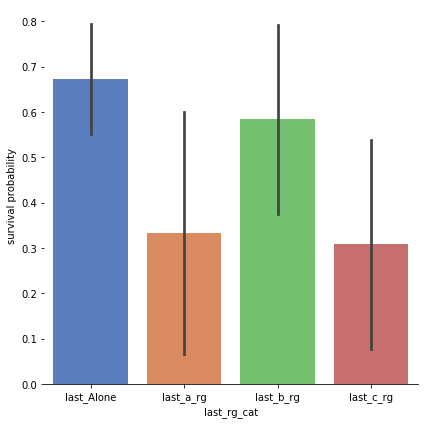

In [208]:
# Explore Parch feature vs Survived
#the black bar is the std deviation and note the size of std dev of Parch = 3 = LARGE
g  = sns.catplot(x="last_rg_cat",y="Survived",data=train[(train.Pclass==3)&(train.m_f==1)&(train.Age<30)],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

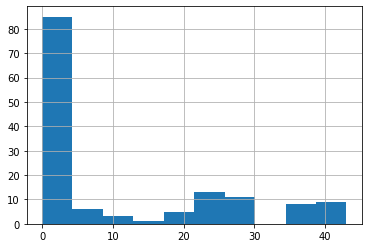

In [178]:
train[(train.Pclass==3)&(train.m_f==1)]['ticket_age_range'].hist()

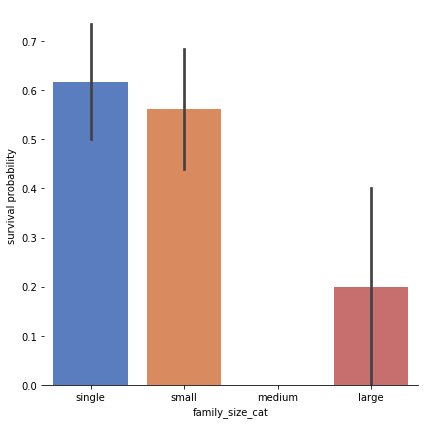

In [89]:
# Explore Parch feature vs Survived
#the black bar is the std deviation and note the size of std dev of Parch = 3 = LARGE
g  = sns.catplot(x="family_size_cat",y="Survived",data=train[(train.Pclass==3)&(train.m_f==1)],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

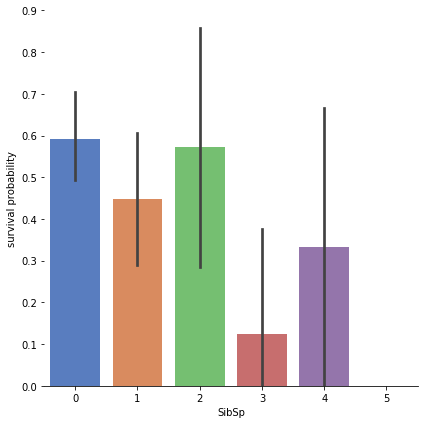

In [91]:
# Explore Parch feature vs Survived
#the black bar is the std deviation and note the size of std dev of Parch = 3 = LARGE
g  = sns.catplot(x="SibSp",y="Survived",data=train[(train.Pclass==3)&(train.m_f==1)],kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [373]:
train[train.title=='Col']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_num,last_name,first_name,family_size,title,rare_title,age_cat,family_size_cat,tix_group,adj_fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.50,A26,...,26.0,Simonius-Blumer,Col. Oberst Alfons,1,Col,1,old,single,1,35.50
695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.55,NaN,...,NaN,Weir,Col. John,1,Col,1,old,single,1,26.55


In [374]:
train[train.title=='Dr']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_num,last_name,first_name,family_size,title,rare_title,age_cat,family_size_cat,tix_group,adj_fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
246,0,1,"Minahan, Dr. William Edward",male,44.00,2,0,19928,90.0000,C78,...,78.0,Minahan,Dr. William Edward,3,Dr,1,mid_life,small,2,45.0000
318,0,2,"Moraweck, Dr. Ernest",male,54.00,0,0,29011,14.0000,NaN,...,NaN,Moraweck,Dr. Ernest,1,Dr,1,old,single,1,14.0000
399,0,2,"Pain, Dr. Alfred",male,23.00,0,0,244278,10.5000,NaN,...,NaN,Pain,Dr. Alfred,1,Dr,1,young_adult,single,1,10.5000
633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.00,0,0,13214,30.5000,B50,...,50.0,Stahelin-Maeglin,Dr. Max,1,Dr,1,mid_life,single,1,30.5000
661,1,1,"Frauenthal, Dr. Henry William",male,50.00,2,0,PC 17611,133.6500,NaN,...,NaN,Frauenthal,Dr. Henry William,3,Dr,1,old,small,2,66.8250
767,0,1,"Brewe, Dr. Arthur Jackson",male,45.75,0,0,112379,39.6000,NaN,...,NaN,Brewe,Dr. Arthur Jackson,1,Dr,1,old,single,1,39.6000
797,1,1,"Leader, Dr. Alice (Farnham)",female,49.00,0,0,17465,25.9292,D17,...,17.0,Leader,Dr. Alice (Farnham),1,Dr,1,old,single,1,25.9292


In [380]:
train[train.title=='Jonkheer']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_num,last_name,first_name,family_size,title,rare_title,age_cat,family_size_cat,tix_group,adj_fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,...,NaN,Reuchlin,Jonkheer. John George,1,Jonkheer,1,mid_life,single,1,0.0


In [ ]:
#factor plot of family size vs survival
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [52]:
#ONEHOT encode the cabin_alpha column from letters to numbers
# we can then use this calculate correlation and assigned everyone to a cabin_alpha = class


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

#cat_cols_list = ['cabin_alpha','title']
cat_cols_list = ['title']

for cat_cols in cat_cols_list:
    x = list(train[cat_cols].unique().reshape(-1,1))

    #cat_cols = ['Sex','Embarked','Ticket','Cabin']
    #x = train[cat_cols].values
    enc.fit(x)
    onehot = enc.transform(train[cat_cols].values.reshape(-1,1)).toarray()

    #put onehot into df to later merge with data
    onehot_train_df = pd.DataFrame(data=onehot,columns=enc.categories_[0])
    onehot_train_df.set_index(train.index,inplace=True)

    #merge results
    X = X.merge(onehot_train_df,left_index=True,right_index=True)

    onehot = enc.transform(test[cat_cols].values.reshape(-1,1)).toarray()

    #put onehot into df to later merge with data
    onehot_test_df = pd.DataFrame(data=onehot,columns=enc.categories_[0])
    onehot_test_df.set_index(test.index,inplace=True)

    #merge results
    gs_test = gs_test.merge(onehot_test_df,left_index=True,right_index=True)


In [72]:
train[(train.m_f==0)].groupby(['Pclass','Survived']).count()/train[(train.m_f==0)].groupby(['Pclass']).count()

Age     Cabin  Embarked      Fare      Name     Parch  \
Pclass Survived                                                               
1      0         0.631148  0.589474  0.631148  0.631148  0.631148  0.631148   
       1         0.368852  0.410526  0.368852  0.368852  0.368852  0.368852   
2      0         0.842593  0.333333  0.842593  0.842593  0.842593  0.842593   
       1         0.157407  0.666667  0.157407  0.157407  0.157407  0.157407   
3      0         0.864553  0.700000  0.864553  0.864553  0.864553  0.864553   
       1         0.135447  0.300000  0.135447  0.135447  0.135447  0.135447   

                      Sex     SibSp  Survived    Ticket  ...  first_name_y  \
Pclass Survived                                          ...                 
1      0         0.631148  0.631148       NaN  0.631148  ...      0.631148   
       1         0.368852  0.368852       NaN  0.368852  ...      0.368852   
2      0         0.842593  0.842593       NaN  0.842593  ...      0.842593   
       1         0.157407  0.157407       NaN  0.157407  ...      0.157407   
3      0         0.864553  0.864553       NaN  0.864553  ...      0.864553   
       1         0.135447  0.135447       NaN  0.135447  ...      0.135447   

                 last_name  last_name_x  last_name_y       m_f  name_len  \
Pclass Survived                                                            
1      0          0.631148     0.631148     0.631148  0.631148  0.631148   
       1          0.368852     0.368852     0.368852  0.368852  0.368852   
2      0          0.842593     0.842593     0.842593  0.842593  0.842593   
       1          0.157407     0.157407     0.157407  0.157407  0.157407   
3      0          0.864553     0.864553     0.864553  0.864553  0.864553   
       1          0.135447     0.135447     0.135447  0.135447  0.135447   

                 rare_title  ticket_alpha     title  tix_group  
Pclass Survived                                                 
1      0           0.631148      0.631148  0.631148   0.631148  
       1           0.368852      0.368852  0.368852   0.368852  
2      0           0.842593      0.842593  0.842593   0.842593  
       1           0.157407      0.157407  0.157407   0.157407  
3      0           0.864553      0.864553  0.864553   0.864553  
       1           0.135447      0.135447  0.135447   0.135447  

[6 rows x 28 columns]

In [73]:
train[(train.m_f==0)].groupby(['Age','Survived']).count()/train[(train.m_f==0)].groupby(['Age']).count()

,,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,...,first_name_y,last_name,last_name_x,last_name_y,m_f,name_len,rare_title,ticket_alpha,title,tix_group
Age,Survived,,,,,,,,,,,,,,,,,,,,,
0.42,1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.67,1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.83,1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.92,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.00,0,0.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,NaN,0.4,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70.00,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
70.50,0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
71.00,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [78]:
train['Age'].head()

PassengerId
1    22.0
2    38.0
3    26.0
4    35.0
5    35.0
Name: Age, dtype: float64

In [77]:
pd.cut(train['Age'],[0,6,15,25,45,100],labels=['baby','child','young_adult','mid_life','old'])

PassengerId
1      young_adult
2         mid_life
3         mid_life
4         mid_life
5         mid_life
          ...     
887       mid_life
888    young_adult
889       mid_life
890       mid_life
891       mid_life
Name: Age, Length: 891, dtype: category
Categories (5, object): [baby < child < young_adult < mid_life < old]

In [21]:
wrong = [40, 622, 448, 193, 674, 397, 236, 205,  24, 773, 313, 358, 255,
            713, 339, 443, 287, 210, 293, 605, 579,  50, 855,  34, 658,  98,
            853,  26, 383, 119, 537,  56,  82, 763, 391, 378, 200]

In [32]:
bad = train.loc[wrong]
bad_male = bad[bad['m_f']==0]
bad_female = bad[bad['m_f']==1]

In [34]:
len(bad_male), len(bad_female)

(22, 15)

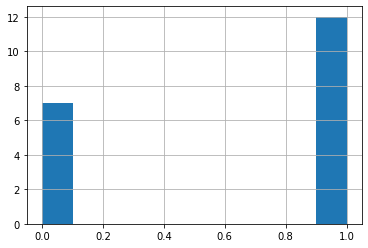

In [31]:
bad['m_f'][bad['Survived']==0].hist()

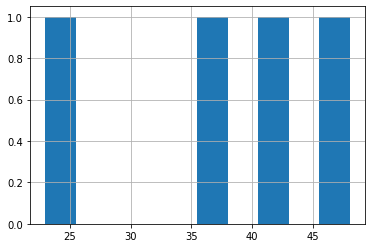

In [45]:
bad_male['Age'][(bad_male.family_size>1)&(bad_male.Survived==1)].hist()

In [48]:
bad_male

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_bin,ticket_alpha,cabin_alpha,cabin_num,last_name,first_name,family_size,tix_group,adj_fare,title
PassengerId,,,,,,,,,,,,,,,,,,,,,
622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,...,1,0,D,19.0,Kimball,Mr. Edwin Nelson Jr,2,1,52.5542,Mr
448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,...,0,0,U,NaN,Seward,Mr. Frederic Kimber,1,1,26.5500,Mr
674,1,2,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,...,0,0,U,NaN,Wilhelms,Mr. Charles,1,1,13.0000,Mr
205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,...,0,1,U,NaN,Cohen,"Mr. Gurshon ""Gus""",1,1,8.0500,Mr
24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,...,1,0,A,6.0,Sloper,Mr. William Thompson,1,1,35.5000,Mr
713,1,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,...,1,0,C,126.0,Taylor,Mr. Elmer Zebley,2,2,26.0000,Mr
339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,...,0,0,U,NaN,Dahl,Mr. Karl Edwart,1,1,8.0500,Mr
443,0,3,"Petterson, Mr. Johan Emil",male,25.0,1,0,347076,7.7750,NaN,...,0,0,U,NaN,Petterson,Mr. Johan Emil,2,1,7.7750,Mr
287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,...,0,0,U,NaN,de Mulder,Mr. Theodore,1,1,9.5000,Mr


In [49]:
bad_female

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_bin,ticket_alpha,cabin_alpha,cabin_num,last_name,first_name,family_size,tix_group,adj_fare,title
PassengerId,,,,,,,,,,,,,,,,,,,,,
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,...,0,0,U,NaN,Nicola-Yarred,Miss. Jamila,2,2,5.620850,Miss
193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,...,0,0,U,NaN,Andersen-Jensen,Miss. Carla Christine Nielsine,2,1,7.854200,Miss
397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,...,0,0,U,NaN,Olsson,Miss. Elina,1,1,7.854200,Miss
236,0,3,"Harknett, Miss. Alice Phoebe",female,32.5,0,0,W./C. 6609,7.5500,NaN,...,0,1,U,NaN,Harknett,Miss. Alice Phoebe,1,1,7.550000,Miss
773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,...,1,1,E,77.0,Mack,Mrs. (Mary),1,2,5.250000,Mrs
313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,...,0,0,U,NaN,Lahtinen,Mrs. William (Anna Sylfven),3,1,26.000000,Mrs
358,0,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,NaN,...,0,0,U,NaN,Funk,Miss. Annie Clemmer,1,1,13.000000,Miss
255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,...,0,0,ZP,NaN,Rosblom,Mrs. Viktor (Helena Wilhelmina),3,2,10.106250,Mrs
579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,28.0,1,0,2689,14.4583,NaN,...,0,0,U,NaN,Caram,Mrs. Joseph (Maria Elias),2,1,14.458300,Mrs


In [47]:
bad_male[(bad_male.family_size>1)&(bad_male.Survived==1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cabin_bin,ticket_alpha,cabin_alpha,cabin_num,last_name,first_name,family_size,tix_group,adj_fare,title
PassengerId,,,,,,,,,,,,,,,,,,,,,
622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,...,1,0,D,19.0,Kimball,Mr. Edwin Nelson Jr,2,1,52.5542,Mr
713,1,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,...,1,0,C,126.0,Taylor,Mr. Elmer Zebley,2,2,26.0000,Mr
98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,...,1,1,D,10.0,Greenfield,Mr. William Bertram,2,1,63.3583,Mr
391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,...,1,0,B,96.0,Carter,Mr. William Ernest,4,4,30.0000,Mr


In [ ]:
train['Parch'][train['cabin_alpha'] == 'B'].hist()

In [ ]:
rel_cols = ['Pclass','m_f','Parch','name_len','cabin_bin','ticket_alpha']

In [ ]:
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch']

#fill missing age with average of sex, Sibsp, Parch, Pclass
col = 'Age'
for i in train.index:
    if np.isnan(train[col].loc[i]):
        #print('Age ',i)
        train[col].loc[i] = train[(train[rel_cols[0]]==train[rel_cols[0]].loc[i])&(train[rel_cols[1]]==train[rel_cols[1]].loc[i])&(train[rel_cols[2]]==train[rel_cols[2]].loc[i])&(train[rel_cols[3]]==train[rel_cols[3]].loc[i])]['Age'].mean()
        if np.isnan(train[col].loc[i]):
            train[col].loc[i] = train[col].mean()



#fill missing age with average of sex, Sibsp, Parch, Pclass
col = 'Age'
for i in test.index:
    if np.isnan(test[col].loc[i]):
        #print('Age ',i)
        test[col].loc[i] = test[(test[rel_cols[0]]==test[rel_cols[0]].loc[i])&(test[rel_cols[1]]==test[rel_cols[1]].loc[i])&(test[rel_cols[2]]==test[rel_cols[2]].loc[i])&(test[rel_cols[3]]==test[rel_cols[3]].loc[i])]['Age'].mean()
        if np.isnan(test[col].loc[i]):
            test[col].loc[i] = test[col].mean()
            
#fill missing embarked with mode of sex, Sibsp, Parch, Pclass
#use code above, filling for now with correct answer
tgt_col = 'Embarked'
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Fare']
train = fill_by_mode(train,tgt_col,rel_cols)

        
tgt_col = 'Fare'
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked']    
test['Fare'].fillna(0,inplace=True)

#train['Cabin'].fillna('None',inplace=True)
#test['Cabin'].fillna('None',inplace=True)

In [ ]:
for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))

In [ ]:
#ONEHOT encode the Ticket column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

cat_cols = 'Ticket'
x = list(train[cat_cols].unique().reshape(-1,1))

#cat_cols = ['Sex','Embarked','Ticket','Cabin']
#x = train[cat_cols].values
enc.fit(x)
onehot = enc.transform(train[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_train_tkt = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_train_tkt.set_index(train.index,inplace=True)

onehot = enc.transform(test[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_test_tkt = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_test_tkt.set_index(test.index,inplace=True)

In [ ]:
columns

In [ ]:
X = train[columns]
X = X.merge(onehot_train_df,left_index=True,right_index=True)
X = X.merge(onehot_train_tkt,left_index=True,right_index=True)

y = train['Survived']

gs_test = test[columns]

gs_test = gs_test.merge(onehot_test_df,left_index=True,right_index=True)
gs_test = gs_test.merge(onehot_test_tkt,left_index=True,right_index=True)

In [ ]:
X.shape[1] == gs_test.shape[1]

In [ ]:
columns

In [ ]:
train.columns

In [ ]:
columns.append('Fare')
columns.append('cabin_bin')
columns.append('ticket_slash')
columns.append('ticket_dot')
columns.append('ticket_space')
columns.append('ticket_alpha')
columns

In [ ]:
columns

In [ ]:
X

In [ ]:
#write X, y and test to csv for use later



In [ ]:
X = train[columns]

In [ ]:
train['Survived'][(train['Age']<10) & (train['Sex']=='female')].hist()

In [ ]:
train['Survived'][train['Sex']=='female'].hist()

In [ ]:
n=8
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=7
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=6
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=5
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=4
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=3
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=2
print(X.columns[n])
X[X.columns[n]].hist()

In [ ]:
n=1
print(X.columns[n])
X[X.columns[n]].hist()

# Visualizations

In [ ]:
init_train

In [ ]:
max_list = []
cat_cols = ['Pclass','Sex','SibSp','Parch','Cabin','Embarked']
for col in cat_cols:
    max_list.append(len(init_train[col].unique()))

In [ ]:
max_list

In [ ]:
init_train[init_train[col]==3].groupby('Survived').count()[col]/len(init_train[init_train[col]==3])

In [ ]:
import matplotlib.pyplot as plt
#plot % survived for each variable

cat_cols = ['Pclass','Sex','SibSp','Parch','Cabin','Embarked']


#fig, axs = plt.subplots(len(cat_cols), 3, sharex=True, sharey=True)

for col in cat_cols:
    for group in init_train[col].unique():
        tgt = init_train[init_train[col]==group]
        print(col,'/',group)
        print(init_train[init_train[col]==group].groupby('Survived').count()[col]/len(init_train[init_train[col]==group]))

In [ ]:
#validation set
X, X_test, y, y_test = train_test_split(X, y, random_state=42)

#scale data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#logistic regression
clf = LogisticRegression(random_state=0).fit(X, y)

print('train score: ',clf.score(X, y))

print('test score: ',clf.score(X_test, y_test))